In [200]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

width = 12
height = 7
plt.rcParams["figure.figsize"] = (width, height)


from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import tflscripts
import json
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn import tree

configuration = tflscripts.read_configuration()
df = pd.read_pickle('results.p')

In [201]:
without_transfer = df.loc[df.type_of_transfer == 'No transfer']
def apply_accuracy_without_transfer(x):
    queried = without_transfer.query('source_device_name == "{}" & source_dataset == "{}" & features == "{}" & label == "{}" & classifier == "{}"'.format(
        x['source_device_name'],
        x['source_dataset'],
        x['features'],
        x['label'],
        x['classifier']
    ))

    if len(queried) > 0:
        return queried['accuracy_positive'].iloc[0]

    return -1

In [202]:
def to_accuracy_bin(acc):
    bins = [
        [0.0, 0.5],
        [0.5, 0.75],
        [0.75, 1.0]
    ]
    return [i for i, b in enumerate(bins) if b[0] <= acc and b[1] >= acc][0]

df['accuracy_bin'] = [to_accuracy_bin(a) for a in df['accuracy_positive']]
filtered = df.loc[df.accuracy_negative >= 0.95]
filtered = filtered.loc[filtered.type_of_transfer != 'No transfer']
filtered = filtered.loc[filtered.type_of_transfer != 'Across spaces']
filtered['accuracy_without_transfer'] = filtered.apply(apply_accuracy_without_transfer, axis=1)

msk = np.random.rand(len(filtered)) <= 0.5
train = filtered[msk]
test = filtered[~msk]

def to_x_and_y(filtered):

    X = filtered[[
        'features',
        'classifier',
        'label',
        'type_of_transfer',
        'accuracy_without_transfer',
        'accuracy_negative'
    ]]

    y = filtered['accuracy_bin']

    X = [dict(r.iteritems()) for _, r in X.iterrows()]
    y = y.values
    
    return X, y

X_train, y_train = to_x_and_y(train)
X_test, y_test = to_x_and_y(test)

ppl = Pipeline([
    ('vect', DictVectorizer()),
    ('impute', Imputer()),
    ('clf', RandomForestClassifier())
])

ppl.fit(X_train, y_train)
predicted = ppl.predict(X_test)
accuracy_score(y_test, predicted)

0.85498687664041995

In [203]:
predictions = pd.Series(predicted)
predictions.index = test.index
df['predictions'] = predictions

df_tested = df.loc[df.predictions >= 0]
counts = df_tested[['accuracy_bin', 'predictions']].groupby(['accuracy_bin', 'predictions']).size()
counts = pd.DataFrame(counts)
counts.columns = ['count']
counts.pivot_table(index=['accuracy_bin'], columns=['predictions'], values=['count'])

count        
predictions    0.0 1.0 2.0
accuracy_bin              
0             1206  26  22
1               63  11  23
2               83   4  86

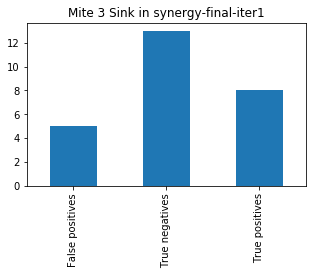

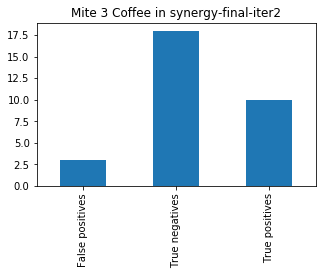

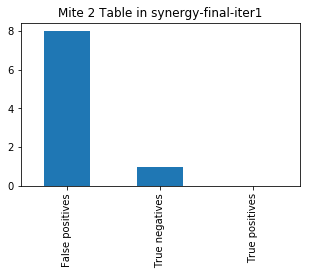

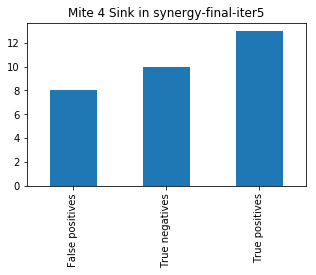

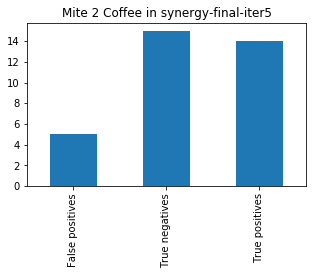

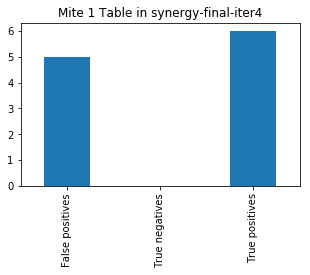

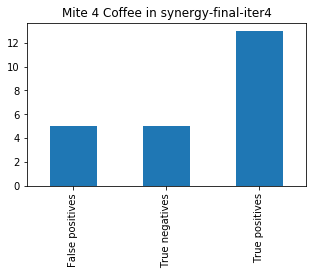

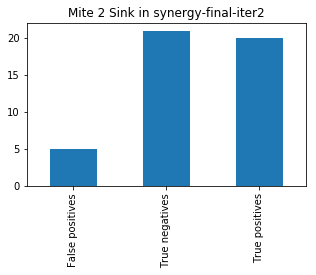

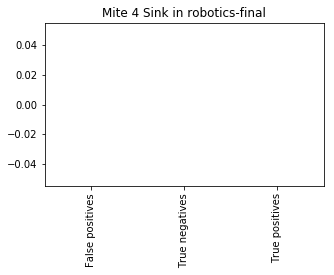

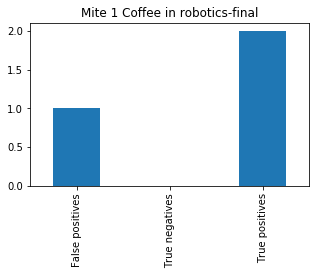

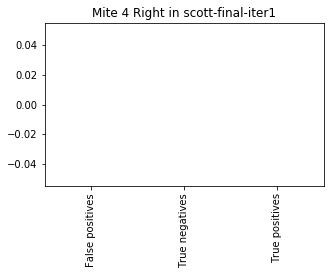

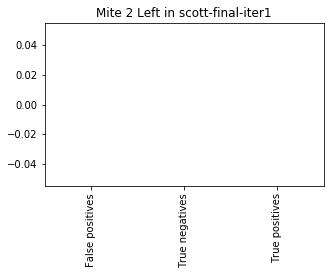

In [204]:
cases = df_tested[['target_device_name', 'target_dataset']].drop_duplicates()
plt.rcParams["figure.figsize"] = (5, 3)

for _, case in cases.iterrows():
    device_name = case['target_device_name']
    dataset = case['target_dataset']
    df_relevant = df_tested.loc[df_tested.target_device_name == device_name]
    df_relevant = df_relevant.loc[df_relevant.target_dataset == dataset]
    
    good_models = df_relevant.loc[df_relevant.accuracy_bin == 2]
    predicted_models = df_relevant.loc[df_relevant.predictions == 2]
    
    true_positives = good_models.loc[good_models.predictions == 2]
    false_positives = predicted_models.loc[predicted_models.accuracy_bin != 2]
    true_negatives = good_models.loc[good_models.predictions == 0]

    pd.Series({
        'True positives': len(true_positives),
        'False positives': len(false_positives),
        'True negatives': len(true_negatives),
    }).plot.bar()
    plt.title(device_name + ' in ' + dataset)
    plt.show()

synergy-final-iter1 Mite 3 Sink


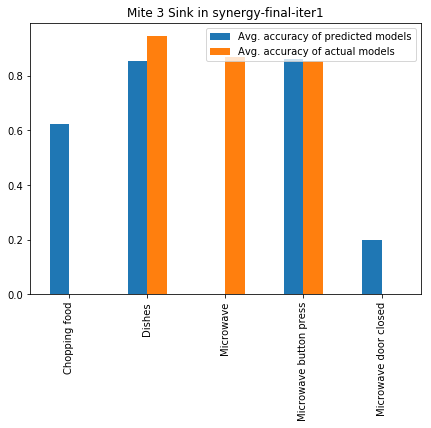

synergy-final-iter2 Mite 3 Coffee


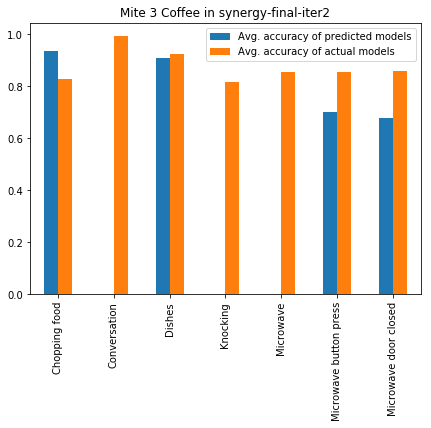

synergy-final-iter1 Mite 2 Table


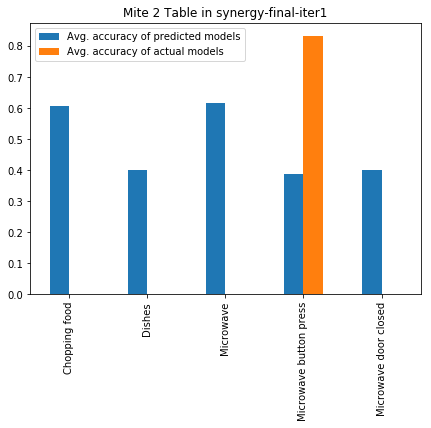

synergy-final-iter5 Mite 4 Sink


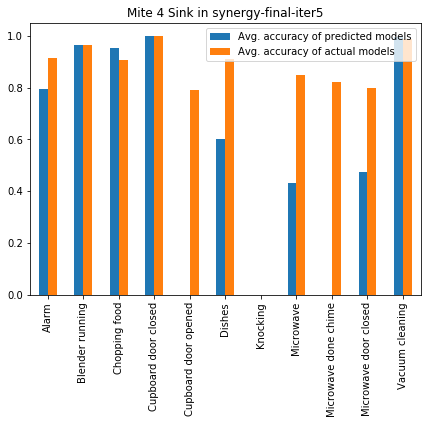

synergy-final-iter5 Mite 2 Coffee


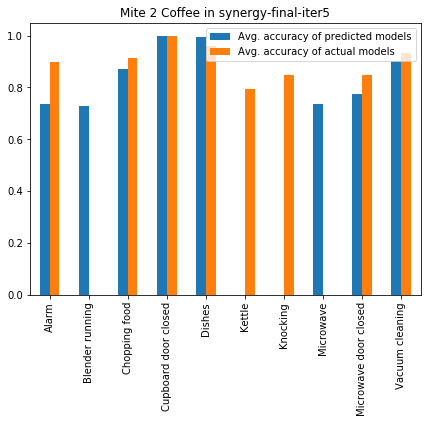

synergy-final-iter4 Mite 1 Table


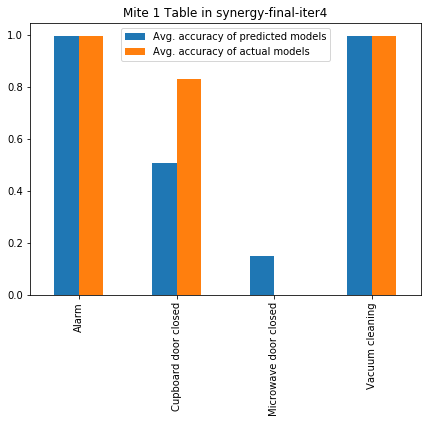

synergy-final-iter4 Mite 4 Coffee


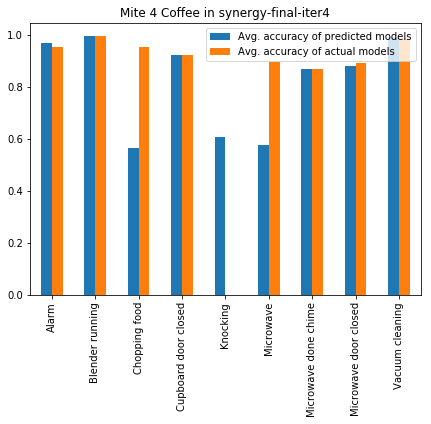

synergy-final-iter2 Mite 2 Sink


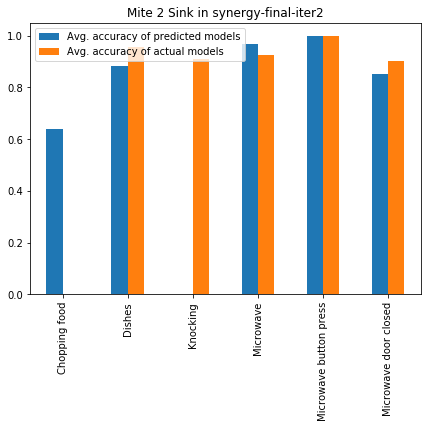

robotics-final Mite 4 Sink


TypeError: Empty 'DataFrame': no numeric data to plot

In [205]:
plt.rcParams["figure.figsize"] = (7, 5)

for _, case in cases.iterrows():
    device_name = case['target_device_name']
    dataset = case['target_dataset']
    print(dataset, device_name)
    df_relevant = df_tested.loc[df_tested.target_device_name == device_name]
    df_relevant = df_relevant.loc[df_relevant.target_dataset == dataset]

    good_models = df_relevant.loc[df_relevant.accuracy_bin == 2]
    predicted_models = df_relevant.loc[df_relevant.predictions == 2]

    predicted_models = predicted_models[['label', 'accuracy_positive']]
    predicted_models = predicted_models.rename(columns={'accuracy_positive': 'Avg. accuracy of predicted models'})
    predicted_models = predicted_models.groupby(['label'])['Avg. accuracy of predicted models'].mean()

    good_models = good_models[['label', 'accuracy_positive']]
    good_models = good_models.rename(columns={'accuracy_positive': 'Avg. accuracy of actual models'})
    good_models = good_models.groupby(['label'])['Avg. accuracy of actual models'].mean()

    pd.concat([predicted_models, good_models], axis=1).plot.bar()

    plt.title(device_name + ' in ' + dataset)
    plt.show()

In [206]:
for _, case in cases.iterrows():
    device_name = case['target_device_name']
    dataset = case['target_dataset']
    print(dataset, device_name)
    df_relevant = df_tested.loc[df_tested.target_device_name == device_name]
    df_relevant = df_relevant.loc[df_relevant.target_dataset == dataset]
    
    print(df_relevant.loc[df_relevant.accuracy_bin == 2][['source_dataset', 'source_device', 'label']].drop_duplicates())
    print(df_relevant.loc[df_relevant.predictions == 2][['source_dataset', 'source_device', 'label']].drop_duplicates())
    
    print('Options', len(df_relevant))
    print('Good options', len(df_relevant.loc[df_relevant.accuracy_bin == 2]))
    print('Good option labels', len(df_relevant.loc[df_relevant.accuracy_bin == 2].label.unique()))
    print(df_relevant.loc[df_relevant.accuracy_bin == 2].label.unique())
    print('Predicted options', len(df_relevant.loc[df_relevant.predictions == 2]))
    print('Predicted option labels', len(df_relevant.loc[df_relevant.predictions == 2].label.unique()))
    print()

synergy-final-iter1 Mite 3 Sink
           source_dataset source_device                   label
217   synergy-final-iter2        Mite 2               Microwave
913   synergy-final-iter2        Mite 2                  Dishes
1397  synergy-final-iter2        Mite 2  Microwave button press
1896  synergy-final-iter2        Mite 3               Microwave
3058  synergy-final-iter2        Mite 3  Microwave button press
8296  synergy-final-iter1        Mite 2               Microwave
9040  synergy-final-iter1        Mite 2                  Dishes
9496  synergy-final-iter1        Mite 2  Microwave button press
           source_dataset source_device                   label
949   synergy-final-iter2        Mite 2                  Dishes
1397  synergy-final-iter2        Mite 2  Microwave button press
3074  synergy-final-iter2        Mite 3  Microwave button press
6900  synergy-final-iter4        Mite 1           Chopping food
8692  synergy-final-iter1        Mite 2           Chopping food
9052  sy

actual,0,1,2
predicted,,,
0,553,25,32
1,40,14,12
2,20,17,63


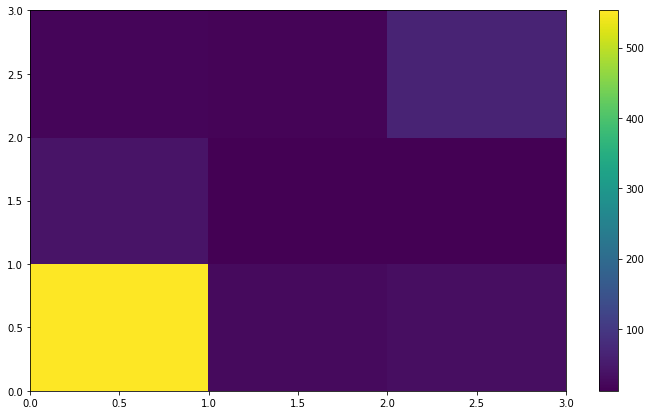

In [16]:
df = pd.DataFrame({'predicted': predicted, 'actual': y_test})
pivoted = df.pivot_table(index='predicted', columns='actual', aggfunc=len, fill_value=0)
plt.pcolor(pivoted)
plt.colorbar()
pivoted

In [9]:
from IPython.display import Image
import pydotplus

clf = ppl.named_steps['clf']

dot_data = tree.export_graphviz(clf, out_file=None,
#                                 feature_names=iris.feature_names,
#                                 class_names=iris.target_names,
                                filled=True, rounded=True,
                                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_pdf("decision_tree.pdf")

True